Video tutorial: https://www.youtube.com/watch?v=S8tpSG6Q2H0 

# Load packages and functions

In [1]:
import os
import datetime
import json
import numpy as np
import pandas as pd 
import ipywidgets as widgets
from ipywidgets import VBox, HBox, interactive, interact
from IPython.display import display, HTML, Javascript
import base64 
import matplotlib.pyplot as plt

def fetchDataFromERDDAP(dataset_id, metadata, variable_list, start_date, end_date):
    try:
        # Set ERDDAP server details
        s = 'https://erddap.marine.ie/erddap' #'http://10.11.1.82/erddap'
        p = 'tabledap'
        r = 'csv'

        param = []
        
        for x in variable_list:
            param.append(x)

        # Generate parameter component of URL
        plist = ''
        for item in metadata + param:
            plist = plist+item+'%2C'
        plist = plist[0:-3]

        # Create dataframe for population
        df = pd.DataFrame()

        # Create ERDDAP url and load data for selected dates  
        url = s+"/"+p+"/"+dataset_id+"."+r+"?"+plist+"&time%3E="+start_date+"T00:00:00Z&time%3C"+end_date+"T23:59:59Z"
        df= pd.read_csv(url,index_col=[0],header=[0],skiprows=[1],parse_dates=True,infer_datetime_format=True)

        #Replace all NaN values with -5
        df = df.fillna(0)

        return df,url
    except Exception as e:
        print(e)
        
def create_download_link(df,Filename,title = "Download CSV file"):  
    csv = df.to_csv(index = True)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=Filename+'.csv')
    display(HTML(html))

# Select Dataset

In [2]:
datsets = ['IWBNetwork']

dcaption = widgets.Label(value='Select ERDDAP dataset for which you wish to run the test:')
dtype = widgets.Dropdown(options=datsets)

def select_dataset(Dataset):
    global dataset
    dataset = Dataset
    print("Selected Dataset: "+dataset)

d = interactive(select_dataset,{'manual': True, 'manual_name':'Select'}, Dataset=dtype)
display(dcaption,d)

Label(value='Select ERDDAP dataset for which you wish to run the test:')

interactive(children=(Dropdown(description='Dataset', options=('IWBNetwork',), value='IWBNetwork'), Button(des…

# Select parameters

In [3]:
dataset_id = dataset
metadata = ['time', 'station_id']
columns = ['AtmosphericPressure','AirTemperature','SeaTemperature','salinity', 'WindSpeed']
default_start_date = datetime.datetime.strptime('2001-02-06', "%Y-%m-%d").date() 
default_end_date = datetime.date.today()

print("Data for this dataset is only avaialable from "+str(default_start_date)+" to "+str(default_end_date)+ ". Please select appropriately!")
    
def load_data(v,sd,ed):
    try:
        global data_full
        global variable_name
        global start_date
        global end_date
        variable_list = v
        if  (default_start_date <= sd <= default_end_date) and (default_start_date <= ed <= default_end_date):
            start_date = str(sd)
            end_date = str(ed)
            data_full,url = fetchDataFromERDDAP(dataset_id, metadata, variable_list, start_date, end_date)
            print("Data Loaded!")
            print("If you wish to download raw dataset as csv file, please click below link:")
            #display(HTML("<a href="+url+">Download</a>"))
            datasetFilename = dataset_id+'_'+start_date+'_'+end_date
            create_download_link(data_full, datasetFilename)
        else:
            raise TypeError("Please select dates within above mentioned date range!")
    except Exception as e:
        print(e)

# Parameter Widgets
## Variable
#vtype = widgets.checkbox(options = columns, description='Variable:')
vtype = widgets.SelectMultiple(
    options=columns,
    value=['SeaTemperature'],
    #rows=10,
    description='Columns',
    disabled=False
)
## Start-End Dates

start_date = default_end_date - datetime.timedelta(days=183)

sdtype = widgets.DatePicker(
    description='Start Date',
    disabled=False,
    value = start_date
)
edtype = widgets.DatePicker(
    description='End Date',
    disabled=False,
    value = default_end_date
)

interactive(load_data,{'manual': True, 'manual_name':'Load'}, v=vtype,sd=sdtype,ed=edtype)

Data for this dataset is only avaialable from 2001-02-06 to 2021-10-29. Please select appropriately!


interactive(children=(SelectMultiple(description='Columns', index=(2,), options=('AtmosphericPressure', 'AirTe…

# Select Station

In [7]:
station_list = data_full.station_id.unique()
scaption = widgets.Label(value='Select station to use:')
stype = widgets.Dropdown(
    options=station_list,
    disabled=False,
)

def select_station(Station):
    global station
    station = Station
    print("Selected Station: "+station)

s = interactive(select_station,{'manual': True, 'manual_name':'Select'}, Station=stype)
display(scaption,s)

Label(value='Select station to use:')

interactive(children=(Dropdown(description='Station', options=('M4', 'M5', 'M2', 'M6', 'M3'), value='M4'), But…

In [8]:
# Dataframe to you use is called 'df'.
df = data_full.loc[data_full['station_id'] == station]
# Omitting 'station_id' column from dataset
df = df[['SeaTemperature']]
df.head(10)

,SeaTemperature
time,
2021-10-22 00:00:00,13.209
2021-10-22 01:00:00,13.112
2021-10-22 02:00:00,13.138
2021-10-22 03:00:00,13.103
2021-10-22 04:00:00,13.059
2021-10-22 05:00:00,13.077
2021-10-22 06:00:00,13.065
2021-10-22 07:00:00,13.079
2021-10-22 08:00:00,13.076


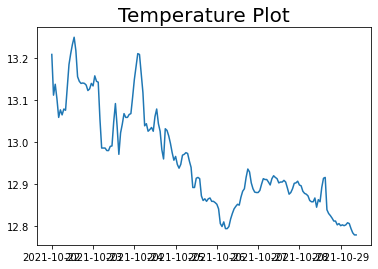

In [9]:
# Visualize
plt.title('Temperature Plot', size=20)
plt.plot(df);

# Train and Test split

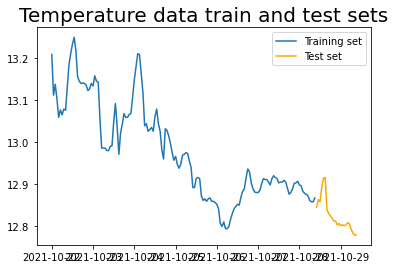

In [10]:
# Splitting the dataset into training and test sets 
# To begin with we will use 7 days worth data for test
# Since the resolution of the data is hourly, we will calculate the test set size based on that
no_of_days = 1
resolution = 24
test_size = no_of_days*resolution 

# Going forward we will use 'df_train' to train the model and 'df_test' to test the accuracy
df_train = df[:-test_size]
df_test = df[-test_size:]

plt.title('Temperature data train and test sets', size=20)
plt.plot(df_train, label='Training set')
plt.plot(df_test, label='Test set', color='orange')
plt.legend();

# Scale Data

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaler.fit(df_train)
scaled_train = scaler.transform(df_train)
scaled_test = scaler.transform(df_test)

# RNN Model

In [12]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [13]:
# define generator
n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train,scaled_train,length=n_input,batch_size=1)

In [14]:
X,y=generator[0]
print(X.flatten())
print(y)

[0.91008772 0.69736842 0.75438596 0.67763158 0.58114035 0.62061404
 0.59429825 0.625      0.61842105 0.73684211 0.85745614 0.91447368]
[[0.9627193]]


In [15]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [16]:
# define Model
model = Sequential()
model.add(LSTM(100,activation='relu',input_shape=(n_input,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss = 'mse')

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [18]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50
142/142 [==============================] - 1s 3ms/step - loss: 0.0331
Epoch 2/50
142/142 [==============================] - 0s 3ms/step - loss: 0.0136
Epoch 3/50
142/142 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 4/50
142/142 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 5/50
142/142 [==============================] - 0s 3ms/step - loss: 0.0105
Epoch 6/50
142/142 [==============================] - 0s 3ms/step - loss: 0.0108
Epoch 7/50
142/142 [==============================] - 0s 3ms/step - loss: 0.0084
Epoch 8/50
142/142 [==============================] - 0s 3ms/step - loss: 0.0087
Epoch 9/50
142/142 [==============================] - 0s 3ms/step - loss: 0.0075
Epoch 10/50
142/142 [==============================] - 0s 3ms/step - loss: 0.0076
Epoch 11/50
142/142 [==============================] - 0s 3ms/step - loss: 0.0076
Epoch 12/50
142/142 [==============================] - 0s 3ms/step - loss: 0.0065
Epoch 13/50
142/142 [====

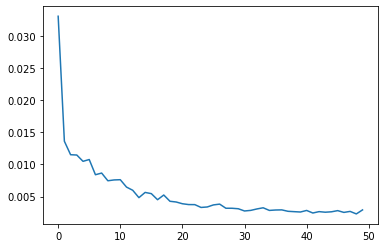

In [19]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [20]:
last_train_batch = scaled_train[-12:]
last_train_batch = last_train_batch.reshape((1,n_input,n_features))

In [21]:
model.predict(last_train_batch)

array([[0.15530328]], dtype=float32)

In [22]:
scaled_test[0]

array([0.11184211])

In [23]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1,n_input,n_features))

for i in range(len(df_test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [24]:
test_predictions

[array([0.15530328], dtype=float32),
 array([0.15446162], dtype=float32),
 array([0.15315056], dtype=float32),
 array([0.15143463], dtype=float32),
 array([0.14959109], dtype=float32),
 array([0.14763372], dtype=float32),
 array([0.14568375], dtype=float32),
 array([0.14397962], dtype=float32),
 array([0.14268002], dtype=float32),
 array([0.14130282], dtype=float32),
 array([0.13978758], dtype=float32),
 array([0.13805881], dtype=float32),
 array([0.13637793], dtype=float32),
 array([0.13466015], dtype=float32),
 array([0.13292071], dtype=float32),
 array([0.13117725], dtype=float32),
 array([0.12946059], dtype=float32),
 array([0.12776196], dtype=float32),
 array([0.12607159], dtype=float32),
 array([0.12438201], dtype=float32),
 array([0.12268985], dtype=float32),
 array([0.12099965], dtype=float32),
 array([0.11931372], dtype=float32),
 array([0.11767859], dtype=float32)]

In [25]:
true_predictions = scaler.inverse_transform(test_predictions)

In [26]:
df_test['Predictions'] = true_predictions

<ipython-input-26-bc5963917119>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Predictions'] = true_predictions


In [27]:
df_test

,SeaTemperature,Predictions
time,,
2021-10-28 10:00:00,12.845,12.864818
2021-10-28 11:00:00,12.863,12.864434
2021-10-28 12:00:00,12.858,12.863837
2021-10-28 13:00:00,12.892,12.863054
2021-10-28 14:00:00,12.914,12.862214
2021-10-28 15:00:00,12.916,12.861321
2021-10-28 16:00:00,12.839,12.860432
2021-10-28 17:00:00,12.830,12.859655
2021-10-28 18:00:00,12.825,12.859062


<AxesSubplot:xlabel='time'>

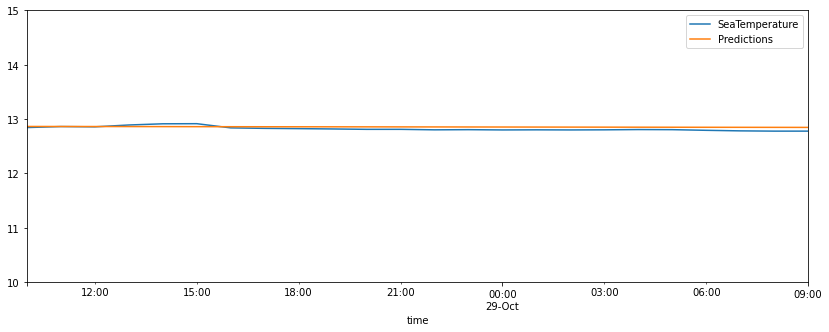

In [33]:
df_test.plot(figsize=(14,5), ylim=(10,15))